## <span style="color:green"> Notebook - Melt Estimation</span>
<span style="color:purple">Sinan Ozaydin, School of Geosciences, The University of Sydney, NSW 2006, Australia <br/> </span>
<span style="color:purple">sinan.ozaydin@protonmail.com | sinan.ozaydin@sydney.edu.au </span>

In this notebook, we will use experimental electrical conductivity measurements.

In [1]:
#Importing the neccesarry python libraries.
import os
import pide
from pide.inversion import conductivity_solver_single_param, conductivity_metropolis_hastings_two_param
from pide.imaging.plot_distribution import plot_posterior_distribution_two_params, plot_posterior_distribution_heatmap_two_params
import numpy as np
import matplotlib.pyplot as plt

/home/sinan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
p_obj = pide.pide()
melt_econd = p_obj.list_melt_econd_models()

Conductivity models for melts:
0.   Sifre2014_Wet_Carbonated
1.   Pommier2008_WetBasalt_Na
2.   Ni2011_WetBasalt
3.   Scarlato2004_DryBasalt_H1604
4.   TyburczyWaff1983_DryTholeiite
5.   TyburczyWaff1983_DryAndesite
6.   Guo2017_WetAndesite
7.   Laumonier2017_WetAndesite
8.   Laumonier2015_WetDacite
9.   Gaillard2004_WetRhyolite
10.   Guo2016_WetRhyolite
11.   Chen2018_WetGranite
12.   Guo2018_WetGranite
13.   Poe2008_Phonotephrite_Average
                 
                 


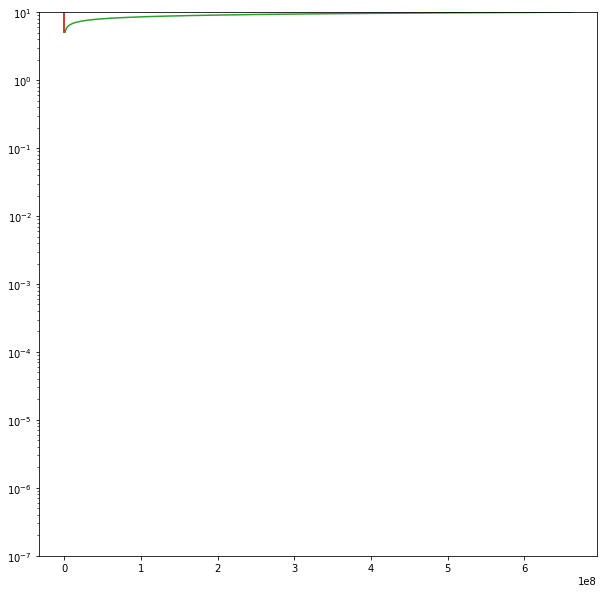

In [18]:
temperature = np.arange(1000,2000,20)
pressure = np.ones(len(temperature)) * 2.0

p_obj.set_temperature(temperature)
p_obj.set_pressure(pressure)

fig = plt.figure(figsize = (10,10))
ax = plt.subplot(111)
melt_cond_dry = []
melt_cond_wet = []
p_obj.set_melt_properties(water = 0)

for i in range(len(melt_econd)):
    
    p_obj.set_melt_fluid_conductivity_choice(melt = i)
    mc = p_obj.calculate_melt_conductivity()
    melt_cond_dry.append(mc)
    ax.plot(melt_cond_dry[i],1e4/temperature,label = melt_econd[i] + '_Dry')

"""
p_obj.set_melt_properties(water = 1000)

for i in range(len(melt_econd)):
    
    p_obj.set_melt_fluid_conductivity_choice(melt = i)
    mc = p_obj.calculate_melt_conductivity()
    melt_cond_wet.append(mc)
    ax.plot(mc,1e3/temperature,label = melt_econd[i] + '_Wet',linestyle = '--')
"""
ax.set_yscale('log')

ax.set_ylim(1e-7,10)

plt.show()
    
    

The estimation of melt content from the given electrical conductivity can be solved with pide for a single parameter. The relationships in melt estimation. Let's first define the environment for the conductivity.

In [2]:
#creating a pide object
p_obj = pide.pide()

#setting up and environment at 1300 K and 3 GPa 
temperature = np.array([1500])
pressure = np.array([3.0])

p_obj.set_temperature(temperature)
p_obj.set_pressure(pressure)

#setting up a simple lherzolite composition
p_obj.set_composition_solid_mineral(ol = 0.6,opx = 0.3, cpx = 0.05, garnet = 0.05)
#setting the mineral conductivity choices
p_obj.set_mineral_conductivity_choice(ol = 4, opx = 0, garnet = 0, cpx = 6)
p_obj.set_solid_phs_mix_method(1) #HS lower bound

#Setting up Sifre2014 as the conductivity choice
p_obj.set_melt_fluid_conductivity_choice(melt = 0)

#Setting up melt CO2
p_obj.set_melt_properties(co2 = 100)

#Setting up bulk water.
#Try to avoid setting up melt_h2o from set_melt properties, because this will not distribute water among minerals.
p_obj.set_bulk_water(300)
p_obj.mantle_water_distribute()

#Setting up the melt-solid mixture relationship to Tubes model
p_obj.set_solid_melt_fluid_mix_method(1)

#Setting up the conductivity value to estimate melt for
cond_external = [1e-1] #or 10 ohm m

#Now setting up the conductivity_solver_single_param
#we are using the parameter melt_fluid_mass_frac to estimate instead volumetric parameter melt_frac.
#This allows us to calculate the thermal expansion and water partitioning among melt and solid minerla mixture
#with more accuracy.
melt_fraction_estimate, residual_list = conductivity_solver_single_param(object = p_obj, cond_list = cond_external,
param_name = 'melt_fluid_mass_frac', upper_limit_list = np.ones(len(temperature)), lower_limit_list= np.zeros(len(temperature)),
search_start = 0.01, acceptence_threshold = 0.5, num_cpu = 1)

print(f'Melt Fraction Estimate: {melt_fraction_estimate[0]}')

Melt Fraction Estimate: 0.2625


Melt fraction can be estimated for the given composition of the environment with a *conductivity_solver_single_param* function. Many of the 

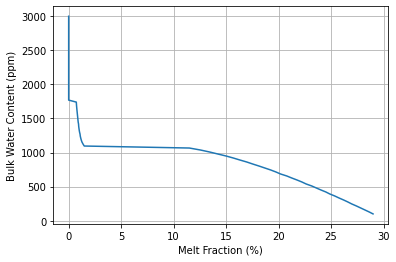

In [3]:
p_obj = pide.pide()

temperature = np.ones(100) * 1500
pressure = np.ones(100) * 3
bulk_water_array = np.linspace(100,3000,100)

p_obj.set_temperature(temperature)
p_obj.set_pressure(pressure)

#setting up a simple lherzolite composition
p_obj.set_composition_solid_mineral(ol = 0.6,opx = 0.3, cpx = 0.05, garnet = 0.05)
#setting the mineral conductivity choices
p_obj.set_mineral_conductivity_choice(ol = 4, opx = 0, garnet = 0, cpx = 6)
p_obj.set_solid_phs_mix_method(1) #HS lower bound

#Setting up Sifre2014 as the conductivity choice
p_obj.set_melt_fluid_conductivity_choice(melt = 0)

#Setting up melt CO2
p_obj.set_melt_properties(co2 = 100)

#Setting up bulk water.
#Try to avoid setting up melt_h2o from set_melt properties, because this will not distribute water among minerals.
p_obj.set_bulk_water(bulk_water_array)
p_obj.mantle_water_distribute()

#Setting up the melt-solid mixture relationship to Tubes model
p_obj.set_solid_melt_fluid_mix_method(1)

cond_external = np.ones(len(temperature)) * 1e-1

#Now setting up the conductivity_solver_single_param
#we are using the parameter melt_fluid_mass_frac to estimate instead volumetric parameter melt_frac.
#This allows us to calculate the thermal expansion and water partitioning among melt and solid minerla mixture
#with more accuracy.
melt_frac_solution, residual_list = conductivity_solver_single_param(object = p_obj, cond_list = cond_external,
param_name = 'melt_fluid_mass_frac', upper_limit_list = np.ones(len(temperature)), lower_limit_list= np.zeros(len(temperature)),
search_start = 0.01, acceptence_threshold = 0.05, num_cpu = 5)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(np.array(melt_frac_solution) * 1e2, bulk_water_array)
ax.set_xlabel('Melt Fraction (%)')
ax.set_ylabel('Bulk Water Content (ppm)')
ax.grid(which = 'both')
plt.show()

Monte-Carlo loop is started
200000 total samples.
10000 burning samples.
Step size (std) for random walk are decreased to [1500, 0.2375] - Acceptance Rate: 0.044- Completed :% 5
Step size (std) for random walk are decreased to [1425.0, 0.2375] - Acceptance Rate: 0.044- Completed :% 6
Step size (std) for random walk are decreased to [1425.0, 0.225625] - Acceptance Rate: 0.044- Completed :% 8
Step size (std) for random walk are decreased to [1425.0, 0.21434374999999997] - Acceptance Rate: 0.042- Completed :% 8
Step size (std) for random walk are decreased to [1353.75, 0.21434374999999997] - Acceptance Rate: 0.043- Completed :% 9
Step size (std) for random walk are decreased to [1353.75, 0.20362656249999997] - Acceptance Rate: 0.042- Completed :% 9
Step size (std) for random walk are decreased to [1353.75, 0.19344523437499997] - Acceptance Rate: 0.042- Completed :% 11
Step size (std) for random walk are decreased to [1353.75, 0.18377297265624995] - Acceptance Rate: 0.042- Completed :% 11


Step size (std) for random walk are decreased to [437.9835365081586, 0.03944480369705669] - Acceptance Rate: 0.101- Completed :% 44
Step size (std) for random walk are decreased to [416.08435968275063, 0.03944480369705669] - Acceptance Rate: 0.101- Completed :% 45
Step size (std) for random walk are decreased to [416.08435968275063, 0.037472563512203856] - Acceptance Rate: 0.103- Completed :% 45
Step size (std) for random walk are decreased to [395.2801416986131, 0.037472563512203856] - Acceptance Rate: 0.105- Completed :% 46
Step size (std) for random walk are decreased to [395.2801416986131, 0.03559893533659366] - Acceptance Rate: 0.106- Completed :% 46
Step size (std) for random walk are decreased to [375.5161346136824, 0.03559893533659366] - Acceptance Rate: 0.109- Completed :% 47
Step size (std) for random walk are decreased to [356.7403278829983, 0.03559893533659366] - Acceptance Rate: 0.111- Completed :% 47
Step size (std) for random walk are decreased to [338.9033114888484, 0.0

Step size (std) for random walk are decreased to [89.30783265829413, 0.009874773476609477] - Acceptance Rate: 0.199- Completed :% 74
Acceptence rate is good size: - Acceptance Rate: 0.202 - Completed :% 74
Acceptence rate is good size: - Acceptance Rate: 0.204 - Completed :% 75
Acceptence rate is good size: - Acceptance Rate: 0.206 - Completed :% 75
Acceptence rate is good size: - Acceptance Rate: 0.208 - Completed :% 76
Acceptence rate is good size: - Acceptance Rate: 0.211 - Completed :% 76
Acceptence rate is good size: - Acceptance Rate: 0.213 - Completed :% 77
Acceptence rate is good size: - Acceptance Rate: 0.215 - Completed :% 77
Acceptence rate is good size: - Acceptance Rate: 0.217 - Completed :% 78
Acceptence rate is good size: - Acceptance Rate: 0.219 - Completed :% 78
Acceptence rate is good size: - Acceptance Rate: 0.221 - Completed :% 79
Acceptence rate is good size: - Acceptance Rate: 0.223 - Completed :% 79
Acceptence rate is good size: - Acceptance Rate: 0.225 - Complet

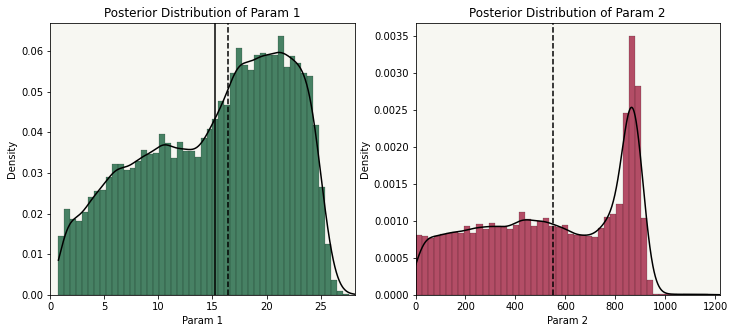

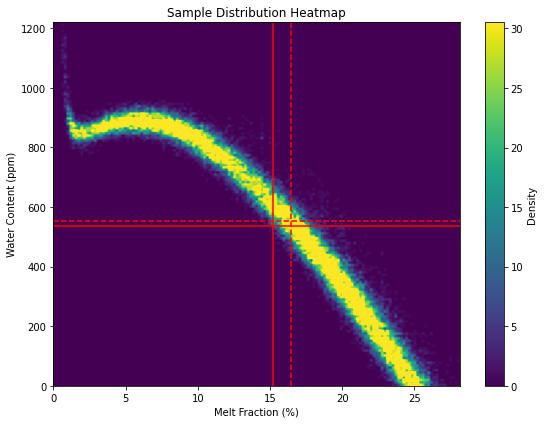

In [4]:
p_obj = pide.pide()

temperature = [1500]
pressure = [3]

p_obj.set_temperature(temperature)
p_obj.set_pressure(pressure)

#setting up a simple lherzolite composition
p_obj.set_composition_solid_mineral(ol = 0.6,opx = 0.3, cpx = 0.05, garnet = 0.05)
#setting the mineral conductivity choices
p_obj.set_mineral_conductivity_choice(ol = 4, opx = 0, garnet = 0, cpx = 6)
p_obj.set_solid_phs_mix_method(1) #HS lower bound

#Setting up Sifre2014 as the conductivity choice
p_obj.set_melt_fluid_conductivity_choice(melt = 0)

#Setting up melt CO2
p_obj.set_melt_properties(co2 = 100)

#Setting up the melt-solid mixture relationship to Tubes model
p_obj.set_solid_melt_fluid_mix_method(1)

cond_external = np.ones(len(temperature)) * 1e-1

#Bounds for the search space.
water_min = np.zeros(len(temperature))
water_max = 3000.0 * np.ones(len(temperature))
melt_min = 0.00 * np.ones(len(temperature))
melt_max = 0.5 * np.ones(len(temperature))

cond_external = [1e-1]
initial_water = 1000
initial_melt = 0.3
initial_params = [[initial_water, initial_melt]]

sigma = 0.01 * np.ones(len(temperature))#in log
n_iterations = 200000
proposal_std = [1500,0.25]
burning = 10000

samples, acceptance_rates, misfits, samples_all, misfits_all = conductivity_metropolis_hastings_two_param(object = p_obj, cond_list = cond_external,
initial_params = initial_params,param_name_1 = 'bulk_water',
param_name_2= "melt_fluid_mass_frac", upper_limits = (water_max,melt_max),
	lower_limits = (water_min,melt_min), sigma_cond = sigma,proposal_stds=proposal_std
	,n_iter = n_iterations, burning = burning, transition_zone = False,num_cpu = 1,adaptive_alg = True,
	step_size_limits = [25000,0.5])

water_samples = samples[0][:, 0]
melt_samples = samples[0][:, 1]

water_samples_all = samples_all[0][:, 0]
melt_samples_all = samples_all[0][:, 1]

In [ ]:
plot_posterior_distribution_two_params(data_param_1 = melt_samples*1e2,data_param_2 = water_samples, file_name = f"melt_frac_distr.png",save = False)
plot_posterior_distribution_heatmap_two_params(data_param_1 = melt_samples*1e2,
data_param_2 = water_samples, param_1_min = 0, param_1_max = np.amax(melt_samples_all)*1e2,
param_2_min = 0, param_2_max = np.amax(water_samples_all),
param1_name = 'Melt Fraction (%)',
param2_name = "Water Content (ppm)",
file_name = f"melt_frac_solution.png",save = False)